In [1]:
!pip install seaborn
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 293 kB 5.5 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 139 kB 8.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 56.4 MB/s eta 0:00:01
     |████████████████████████████████| 214 kB 99.5 MB/s eta 0:00:01


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import torch
import torch.distributions as dist
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
from datetime import datetime
#%matplotlib notebook
random_seed = 1
np.random.seed(seed=random_seed)
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
path = os.path.join(os.getcwd(), "plot/")
today=datetime.today().strftime('%Y-%m-%d')

In [4]:
class FHatNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FHatNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [5]:
class AlphaEmbeddingNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AlphaEmbeddingNetwork, self).__init__()
        
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
   
    def forward(self, alpha):
        # Convert the scalar alpha to a vector
        print("alpha", alpha, alpha.shape)
        alpha_vector = torch.relu(torch.unsqueeze(alpha, 1))
        hidden1 = self.relu(self.linear1(alpha_vector))
        hidden2 = self.relu(self.linear2(hidden1))
        theta = self.relu(self.linear3(hidden2))
        return theta


class HNetwork(nn.Module):
    def __init__(self, embedding_size):
        super(HNetwork, self).__init__()
        self.embedding_network = AlphaEmbeddingNetwork(input_size=1, hidden_size=embedding_size)
        self.f_network = FHatNetwork(embedding_size)
        
    def forward(self, x, alpha):
        # Get the embedding theta from the embedding network
        alpha = torch.tensor([alpha])
        theta = self.embedding_network(alpha)
        self.f_network.linear.weight = theta
        output = self.f_network(x)
        return output

**Preliminaries** In the following, the classes are defined to initiate the aggregation functions $\rho_{\alpha}$ and the aggregated risk minimization (ARM) optimization for a simple 1D and 2D regression task.

In [6]:
class aggregation_function:    
    """ This class aggregates the risks. """
    def __init__(self, name:str):
        self.name = name
    def aggregate(self, risks, alpha) -> float:
        if self.name == 'cvar':
            return self.cvar(risks, alpha)
        else:
            raise NotImplementedError("Currently, only CVaR is implemented.")
    def cvar(self, risks, alpha) -> float:
        var = torch.quantile(risks,alpha, interpolation='linear')
        cvar = risks[risks > var].mean()
        return cvar

In [7]:
class ARM_Regression:
    def __init__(self,name,experiment="1D_linear"):      
        self.aggregator = aggregation_function(name=name)
        
    
    def fit(self, f, env_dict, alpha):        
        """Fit the coefficients of a function f. 

        Parameters
        ----------
        env_dict : dict
        alpha : int

        Returns
        ------
        coef : float
        """
        learning_rate = 0.01
        num_epochs= 200
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(f.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
        for epoch in range(num_epochs):
            risks = torch.stack([loss_fn(env_dict[e]['y'],f(env_dict[e]['x'])) for e in env_dict.keys()])
            cvar = self.aggregator.aggregate(risks, alpha)
            cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return 
    
    def fit_independent_h_loop(self, h, env_dict):
        """Fit the coefficients of a function h in independent optimization. 

        Parameters
        ----------
        env_dict : dict
        alpha : int

        Returns
        ------
        coef : float
        """
        learning_rate = 0.01
        num_epochs=200
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
        for alpha in torch.arange(0,1,0.05):
            for epoch in range(num_epochs): 
                risks = torch.stack([loss_fn(env_dict[e]['y'],h(env_dict[e]['x'], alpha)) for e in env_dict.keys()])
                cvar = self.aggregator.aggregate(risks, alpha)
                optimizer.zero_grad()
                cvar.backward()
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                #if (epoch + 1) % 10 == 0:
                #    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return 
    
    def fit_independent_h_probablistic(self, h, env_dict):
        """Fit the coefficients of a function h in independent optimization  with alpha'~U[0.05,1]. 

        Parameters
        ----------
        env_dict : dict
        alpha : int

        Returns
        ------
        coef : float
        """
        learning_rate = 0.01
        num_epochs=200
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
        for epoch in range(num_epochs): 
            alpha = dist.Uniform(0,1).sample()
            risks = torch.stack([loss_fn(env_dict[e]['y'],h(env_dict[e]['x'], alpha)) for e in env_dict.keys()])
            cvar = self.aggregator.aggregate(risks, alpha)
            cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            #if (epoch + 1) % 10 == 0:
            #    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return
    
    
    def objective_h(self, risks, alpha_prime):
        def pdf_normal_distribution(x, alpha_prime):
            # Create a normal distribution centered at alpha' with std. 1 at alpha'
            likelihood = dist.normal.Normal(loc=alpha_prime, scale=alpha_prime)
            # Calculate the probability density at the point x
            pdf = likelihood.log_prob(x).exp()
            return pdf
        alphas = dist.Uniform(0,1).sample((1000,1))
        objective = 0
        weights = pdf_normal_distribution(alphas, alpha_prime)
        cvars = torch.stack([self.aggregator.aggregate(risks,alpha) for alpha in alphas])
        objective = (weights * cvars).mean()
        return objective
    
    def fit_h(self, h, env_dict):
        """Fit the coefficients of a function h in optimization. 

        Parameters
        ----------
        env_dict : dict
        alpha : int

        Returns
        ------
        coef : float
        """
        learning_rate = 0.01
        num_epochs=200
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
        for epoch in range(num_epochs): 
            alpha_prime = dist.Uniform(0.05,1).sample()
            risks = torch.stack([loss_fn(env_dict[e]['y'],h(env_dict[e]['x'], alpha_prime)) for e in env_dict.keys()])
            loss = self.objective_h(risks, alpha_prime)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            #if (epoch + 1) % 10 == 0:
            #    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return

**Experiment 1** We assume the following *linear* data generation process $$Y(X) = X*\theta_{e}+\epsilon$$ and *nonlinear* data generation process $$Y(X) = sin(X*\theta_{e})+\epsilon$$.

**Experiment 1A** Assume a linear model $Y_{e}=\theta_{e}X+\epsilon$, where $X \sim \mathcal{N}(2,0.2)$ and $\epsilon\sim \mathcal{N}(0,0.1)$. We simulate different environments by drawing $\theta$ from a beta distribution $Beta(0.1,0.2)$. In total, we generate for 25 environments 100 observations each.

**Experiment 1B** Assume the same setting as in Experiment 1, however, in contrast, we simulate different environments by drawing $\theta$ from a uniform distribution $\ \mathcal{U}(0,1)$. In total, we generate for 25 environments 100 observations each.

In [8]:
class data_generator:
    
    """ This class generates the simulation data. """
    

    def __init__(self, envs_train = 25, envs_test = 25, 
                 size_train = 1000, size_test= 100, 
                 theta_dist="uniform",
                 dim=1):
        
        self.envs_train = envs_train
        self.envs_test = envs_test
        self.size_train = size_train
        self.size_test = size_test
        self.theta_dist = theta_dist
        self.dim = dim 
        
    def generate(self) -> dict:           
        env_list_train = [f'e_{i}' for i in range(1,self.envs_train+1,1)]
        env_dict_train = dict(list(enumerate(env_list_train)))
        env_list_test  = [f'e_{i}' for i in range(1,self.envs_test+1,1)]
        env_dict_test  = dict(list(enumerate(env_list_test)))
        
        
        for e_train in env_dict_train.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample((self.dim,1))
            x_train = dist.normal.Normal(loc=1, scale=0.5).sample((self.size_train,self.dim))
            noise_train = dist.normal.Normal(loc=0, scale=0.05).sample((self.size_train,self.dim))
            y_train = x_train@theta_true + noise_train
            env_dict_train[e_train] = {'x': x_train,'y': y_train,'theta_true': theta_true}
            
        for e_test in env_dict_test.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample((self.dim,1))
            x_test = dist.normal.Normal(loc=1, scale=0.5).sample((self.size_test,self.dim))
            noise_test = dist.normal.Normal(loc=0, scale=0.05).sample((self.size_test,self.dim))
            y_test = x_test@theta_true+noise_test
            env_dict_test[e_test] = {'x': x_test,'y': y_test,'theta_true': theta_true}
            
        return env_dict_train, env_dict_test

In [9]:
# Intitialize the experiment and generate the data
envs_train, envs_test = 250, 25
size_train, size_test = 1000 , 1000
theta_dist="beta" 
rho="cvar"
dim = 10
data_generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = data_generator.generate()

'\nfig, axs = plt.subplots(1, 2, figsize=(16, 6))\nax = axs[0]\nX_train = torch.stack([data_dict_train[e][\'x\'] for e in data_dict_train.keys()])\nX_train = np.array(X_train).reshape(-1,1)\nY_train = torch.stack([data_dict_train[e][\'y\'] for e in data_dict_train.keys()])\nY_train = np.array(Y_train).reshape(-1,1)\nax.scatter(y=Y_train, x=X_train, s=3, c="grey", alpha=0.05, label="Training envs")\nax.legend(loc=\'upper left\')\n\nax = axs[1]\nX_test = torch.stack([data_dict_test[e][\'x\'] for e in data_dict_test.keys()])\nX_test = np.array(X_test).reshape(-1,1)\nY_test = torch.stack([data_dict_test[e][\'y\'] for e in data_dict_test.keys()])\nY_test = np.array(Y_test).reshape(-1,1)\nax.scatter(y=Y_test, x=X_test, s=3, c="grey", alpha=0.05, label="Testing envs")\nax.legend(loc=\'upper left\')\nfig.tight_layout()\n'

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [10/200], Loss: 4.917717933654785
Epoch [20/200], Loss: 2.69203782081604
Epoch [30/200], Loss: 2.2877681255340576
Epoch [40/200], Loss: 2.3545453548431396
Epoch [50/200], Loss: 2.318718671798706
Epoch [60/200], Loss: 2.2755210399627686
Epoch [70/200], Loss: 2.2703981399536133
Epoch [80/200], Loss: 2.2653417587280273
Epoch [90/200], Loss: 2.258314609527588
Epoch [100/200], Loss: 2.2531232833862305
Epoch [110/200], Loss: 2.247990369796753
Epoch [120/200], Loss: 2.2428994178771973
Epoch [130/200], Loss: 2.2380502223968506
Epoch [140/200], Loss: 2.2333359718322754
Epoch [150/200], Loss: 2.2288055419921875
Epoch [160/200], Loss: 2.2244858741760254
Epoch [170/200], Loss: 2.2203691005706787
Epoch [180/200], Loss: 2.2164645195007324
Epoch [190/200], Loss: 2.212777614593506
Epoch [200/200], Loss: 2.209333896636963
Epoch [10/200], Loss: 5.974839210510254
Epoch [20/200], Loss: 3.1057183742523193
Epoch [30/200], Loss: 2.372818946838379
Epoch [40/200], Loss: 2.405691146850586
Epoch [50/200], 

Epoch [10/200], Loss: 11.825051307678223
Epoch [20/200], Loss: 6.186828136444092
Epoch [30/200], Loss: 3.9233899116516113
Epoch [40/200], Loss: 3.875627279281616
Epoch [50/200], Loss: 3.9272377490997314
Epoch [60/200], Loss: 3.826097011566162
Epoch [70/200], Loss: 3.7983343601226807
Epoch [80/200], Loss: 3.8001387119293213
Epoch [90/200], Loss: 3.795131206512451
Epoch [100/200], Loss: 3.7906839847564697
Epoch [110/200], Loss: 3.7879676818847656
Epoch [120/200], Loss: 3.785216808319092
Epoch [130/200], Loss: 3.782550811767578
Epoch [140/200], Loss: 3.77984356880188
Epoch [150/200], Loss: 3.7771241664886475
Epoch [160/200], Loss: 3.7744345664978027
Epoch [170/200], Loss: 3.771763324737549
Epoch [180/200], Loss: 3.7691256999969482
Epoch [190/200], Loss: 3.766525983810425
Epoch [200/200], Loss: 3.7639689445495605
Epoch [10/200], Loss: 15.925381660461426
Epoch [20/200], Loss: 8.938072204589844
Epoch [30/200], Loss: 4.951807975769043
Epoch [40/200], Loss: 4.086339950561523
Epoch [50/200], Lo

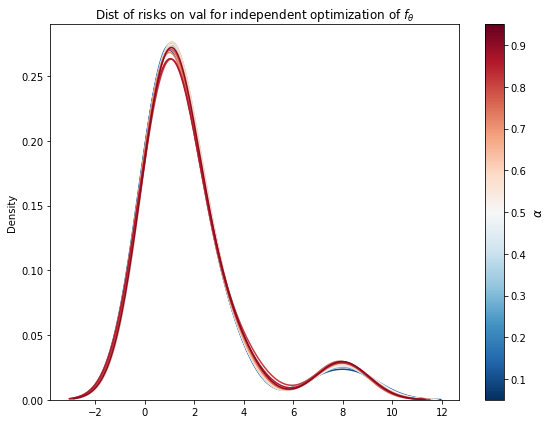

In [10]:
#Run the ARM regression task
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "theta_hat", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = range(5,100,5)
diverging_colors = sns.color_palette("RdBu", len(rg))
j=1

for i in tqdm(rg):
    f = FHatNetwork(dim)
    ARM_Regression(name=rho).fit(f, data_dict_train, i/100)  
    with torch.no_grad():
        risks = torch.stack([loss_fn(data_dict_test[e]['y'], f(data_dict_test[e]['x'])) for e in data_dict_test.keys()])
        cvar_emp = aggregation_function(name="cvar").aggregate(risks, i/100)     
        sns.kdeplot(risks.numpy(), ax=ax,color=diverging_colors[len(rg)-j], label=str(i/100))
    
    results.at[i, "alpha"] = i/100
    results.at[i, "theta_hat"] = f.state_dict()
    results.at[i, "cvar"] = cvar_emp
    j+=1
    del(f)
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
#ax.set_title(r"Distribution of the risks on the training data ($\alpha$)")
ax.set_title(r"Dist of risks on val for independent optimization of $f_\theta$")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

plt.tight_layout()

alpha tensor([0.]) torch.Size([1])


TypeError: cannot assign 'torch.FloatTensor' as parameter 'weight' (torch.nn.Parameter or None expected)

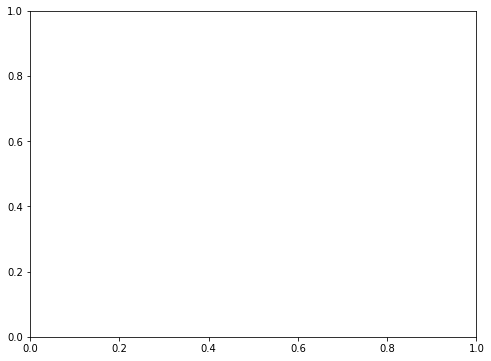

In [11]:
#Run the ARM regression task
h = HNetwork(dim)
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "theta_hat", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = range(5,100,5)
diverging_colors = sns.color_palette("RdBu", len(rg))
j=1

ARM_Regression(name=rho).fit_independent_h_loop(h, data_dict_train)  
h.eval()
for i in tqdm(rg):
    risks = torch.stack([loss_fn(data_dict_test[e]['y'], h(data_dict_test[e]['x'],i/100)) for e in data_dict_test.keys()])
    cvar_emp = aggregation_function(name="cvar").aggregate(risks, i/100)
             
    sns.kdeplot(np.array(risks), ax=ax,color=diverging_colors[len(rg)-j], label=str(i/100))
    
    results.at[i, "alpha"] = i/100
    results.at[i, "theta_hat"] = theta[0]
    results.at[i, "cvar"] = cvar_emp
    j+=1
    
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax.set_title(r"Dist of risks on val for iterative independent optimization of $h_\beta(x,\alpha')$")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

plt.tight_layout()
del(h)

In [ ]:
#Run the ARM regression task
h = HNetwork(dim)
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "theta_hat", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = range(5,100,5)
diverging_colors = sns.color_palette("RdBu", len(rg))
j=1
ARM_Regression(name=rho).fit_independent_h_probablistic(h, data_dict_train)  
h.eval()
for i in tqdm(rg):
    risks = torch.stack([loss_fn(data_dict_test[e]['y'], h(data_dict_test[e]['x'],i/100)) for e in data_dict_test.keys()])
    cvar_emp = aggregation_function(name="cvar").aggregate(risks, i/100)
             
    sns.kdeplot(np.array(risks), ax=ax,color=diverging_colors[len(rg)-j], label=str(i/100))
    
    results.at[i, "alpha"] = i/100
    results.at[i, "theta_hat"] = theta[0]
    results.at[i, "cvar"] = cvar_emp
    j+=1
    
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax.set_title(r"Dist of risks on val for independent optimization of $h_\beta(x,\alpha')$ $\alpha' \sim U[0,1]$")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

plt.tight_layout()
del(h)

In [ ]:
#Run the ARM regression task
h = HNetwork(dim)
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "theta_hat", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = range(5,100,5)
diverging_colors = sns.color_palette("RdBu", len(rg))
j=1
ARM_Regression(name=rho).fit_h(h, data_dict_train) 
h.eval()
for i in tqdm(rg):
    risks = torch.stack([loss_fn(data_dict_test[e]['y'], h(data_dict_test[e]['x'],i/100)) for e in data_dict_test.keys()])
    cvar_emp = aggregation_function(name="cvar").aggregate(risks, i/100)
             
    sns.kdeplot(np.array(risks), ax=ax,color=diverging_colors[len(rg)-j], label=str(i/100))
    
    results.at[i, "alpha"] = i/100
    results.at[i, "theta_hat"] = theta[0]
    results.at[i, "cvar"] = cvar_emp
    j+=1
    
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax.set_title(r"Dist of risks on val for direct optimization (Our Method)")

norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

plt.tight_layout()

In [ ]:
#Plot the CVAR landscape and the estimated thetas

step_size= 0.1
rg_alpha = np.arange(0, 1, step_size)
rg_theta = np.arange(0, 1, step_size)
output_list = list(itertools.product(*[rg_alpha, rg_theta]))

def array_for_heatmap(data_dict, alpha, theta):

    risks = [mean_squared_error(data_dict[e]['y'], f(data_dict[e]['x'], theta)) for e in data_dict.keys()]
    cvar = aggregation_function(name="cvar").aggregate(risks, alpha*100)
    
    return [np.round(alpha, 3), np.round(theta, 3), np.round(cvar, 3)]

temp = Parallel(n_jobs=8)(delayed(array_for_heatmap)(data_dict, j[0], j[1]) for j in tqdm(output_list))

# Prepare the data for the landscape plot
index, columns = np.unique([i[0] for i in temp]), np.unique([i[0] for i in temp])

landscape = pd.DataFrame(index=index, columns=columns)

for i in temp:
    landscape.at[i[0], i[1]] = float(i[2]) #if not np.nan else np.nan
    
landscape = landscape.sort_index(ascending=False).apply(pd.to_numeric, errors='coerce')

del temp


fig, ax = plt.subplots(1,1, figsize=(8,6))

vmin, vmax=0.0, 1.5

img = ax.imshow(landscape,extent=[0,1,0,1], interpolation='bilinear', cmap="Greens", vmin=vmin, vmax=vmax) #extent=[0,1,0,1]

plt.xlabel(r'$\Theta$', fontsize = 16)
plt.ylabel(r'$\alpha$', fontsize = 16)
img = ax.scatter(y=results.alpha, x=results.theta_hat, c = results.cvar, edgecolors='black', cmap = 'Greens', vmin=vmin, vmax=vmax, label="Independent")
ax.set_title(r"Landscape for $CVaR_{\alpha}(\theta)$ and circles represent $\hat{\theta}$")
fig.colorbar(img).set_label(label='CVaR value',labelpad=5,size=12)
plt.legend()

In [ ]:
#Plot the data and the estimated regression function

j=1
fig, ax = plt.subplots(1,1, figsize=(8,6))

X_train = [data_dict[e]['x'].ravel() for e in data_dict.keys()]
X_train = np.array([item for sublist in X_train for item in sublist]).reshape(-1,1)
Y_train = [data_dict[e]['y'] for e in data_dict.keys()]
Y_train = np.array([item for sublist in Y_train for item in sublist]).reshape(-1,1)

ax.scatter(y=Y_train, x=X_train, s=3, c="grey", alpha=0.05, label="Training envs")
ax.legend(loc='upper left')

diverging_colors = sns.color_palette("RdBu", len(results))

for index, row in results.iterrows():

    x_plt = np.arange(0,4,0.1)
    ax.plot(x_plt, f(x_plt, row['theta_hat']), c =diverging_colors[len(results)-j], alpha=0.5, label="Test envs")
    j+=1

norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

ax.axis(xmin=0,xmax=3)
ax.axis(xmin=0,xmax=3)

ax.set_title("Generated data")
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$Y$")

ax.set_xlabel(r"$X$")
ax.set_title(r"Estimated regression functions $h(\alpha,x)$")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

alpha_plt = np.arange(0, 1, 0.05)
x_plt = np.arange(4, 6, 0.01)

h = np.array([f(x,theta) for theta in list(results['theta_hat']) for x in x_plt]).reshape(len(alpha_plt), len(x_plt))

plt.figure()
plt.pcolor(x_plt, alpha_plt, h, cmap=plt.get_cmap('RdPu'))
contour = plt.contour(x_plt, alpha_plt, h, colors='black', levels=10)  # Add contour lines
plt.xlabel(r"$X$")
plt.ylabel(r"$\alpha$")
plt.title(r"$h(X,\alpha)$")
plt.colorbar(contour)  # Add color to the color bar
plt.show()

**Experiment 2** We assume the following *linear* data generation process $$Y(X_{1},X_{2}) = X_{1}^{2}*\theta_{1,e}+X_{2}*\theta_{2,e}+\epsilon$$ and the following non-linear data generation process

$$Y(X_{1},X_{2}) = \exp^{-\sqrt{X_{1}*\theta_{1,e}+X_{2}*\theta_{2,e}}}+\epsilon$$


In [ ]:
h = h_hat(experiment)
results = pd.DataFrame(columns = ["alpha", "theta_hat", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
alpha_hat = range(1,100,1)
diverging_colors = sns.color_palette("RdBu", len(alpha_hat))
j=1

for i in tqdm(alpha_hat):
    f = lambda x, theta: h(x,theta,i)
    theta_hat = ARM_Regression(name=rho, experiment=experiment).fith(f, data_dict, i)  
    risks = [mean_squared_error(data_dict[e]['y'], f(data_dict[e]['x'], theta_hat)) for e in data_dict.keys()]
    cvar_emp = aggregation_function(name="cvar").aggregate(risks, i)
    
    sns.kdeplot(risks, ax=ax,color=diverging_colors[len(alpha_hat)-j], label=str(i/100))
    
    results.at[i, "alpha"] = i/100
    results.at[i, "theta_hat"] = theta_hat[0]
    results.at[i, "cvar"] = cvar_emp
    j+=1
    
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax.set_title(r"Distribution of the risks on the training data ($\alpha$)")

norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

plt.tight_layout()